In [1]:
# Alle notwendigen Import werden Hier gemacht

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, json
from pathlib import Path
import json

In [2]:
import math

def cholesky_factorization(a): # A*lambda=b  wobei A=x(mittelpunkt der Bereichen, b=y ( q95 der Laufzeiten jedre Bereich))
    n = len(a)
    l = [[0.0 for _ in range(n)] for _ in range(n)]
    for i in range(n):
        for j in range(i + 1):
            sum_val = sum(l[i][k] * l[j][k] for k in range(j))
            if i == j:
                l[i][j] = math.sqrt(a[i][i] - sum_val)
            else:
                l[i][j] = (a[i][j] - sum_val) / l[j][j]
    return l

def forward_substitution(l, b):
    n = len(b)
    y = [0.0 for _ in range(n)]
    y[0] = b[0] / l[0][0]
    for i in range(1, n):
        sume = sum(l[i][j] * y[j] for j in range(i))
        y[i] = (b[i] - sume) / l[i][i]
    return y

def backward_substitution(lt, y):
    n = len(y)
    x = [0.0 for _ in range(n)]
    x[n - 1] = y[n - 1] / lt[n - 1][n - 1]

    for i in range(n - 2, -1, -1):
        sume = sum(lt[i][j] * x[j] for j in range(i + 1, n))
        x[i] = (y[i] - sume) / lt[i][i]
       
    return x

def solve_linear_equation_system(a, b):
    n = len(b)
    l = cholesky_factorization(a)
    # Transposer L pour avoir L^T
    lt = [[l[j][i] for j in range(n)] for i in range(n)]
    y = forward_substitution(l, b)
    x = backward_substitution(lt, y)
    return x


In [3]:
# Methode zum Einlesen der Daten und Berechnen der Laufszeiten.

def read_and_compute_runtime(filename):
    df = pd.read_csv(filename, sep=r"\s+", header=None,
                     names=["id", "start", "pre_end", "solver_end"])

    time_format = "%d.%m.%Y-%H:%M:%S"
    df["start"] = pd.to_datetime(df["start"], format=time_format)
    df["solver_end"] = pd.to_datetime(df["solver_end"], format=time_format)
    df["runtime_s"] = (df["solver_end"] - df["start"]).dt.total_seconds()

    return df

# r1=read_and_compute_runtime("runtimes.mp80")
#print(r1)


In [4]:
#Methode read_and_compute_runtime aufrufen, Laufzeiten, Mittelwerte, Varianz , median und standardabweichungen  von Jede Prozessor berechnen
# und in einem DataFrame (~ Dictionary ) speichern 

files = {
    "Intel N95 (mp80)": "runtimes.mp80",
    "Intel N100": "runtimes.n100",
    "Raspberry Pi 5": "runtimes.pi5"
}

data = {name: read_and_compute_runtime(path) for name, path in files.items()}
#print(data)

results=[]
for name, df in data.items():
    mean = df["runtime_s"].mean()
    median = df["runtime_s"].median()
    var = df["runtime_s"].var()
    std = df["runtime_s"].std()
    max=df["runtime_s"].max()
    min=df["runtime_s"].min()
    
    
    results.append({'Name': name,'Mean': mean,'Median': median,'Varianz': var, 'Standardabweichung': std, 'MinZeit (in Sekunden)': min,'MaxZeit(in Sekunden': max})

# jetz als DataFrame umwandeln
mmvs_df = pd.DataFrame(results)

print(mmvs_df)

               Name      Mean  Median        Varianz  Standardabweichung  \
0  Intel N95 (mp80)   58.5965    44.0    4801.035205           69.289503   
1        Intel N100   43.9185    34.0    2717.963840           52.134095   
2    Raspberry Pi 5  110.0830    67.0  133378.350286          365.210008   

   MinZeit (in Sekunden)  MaxZeit(in Sekunden  
0                    7.0               1538.0  
1                    8.0               1518.0  
2                   10.0              14990.0  


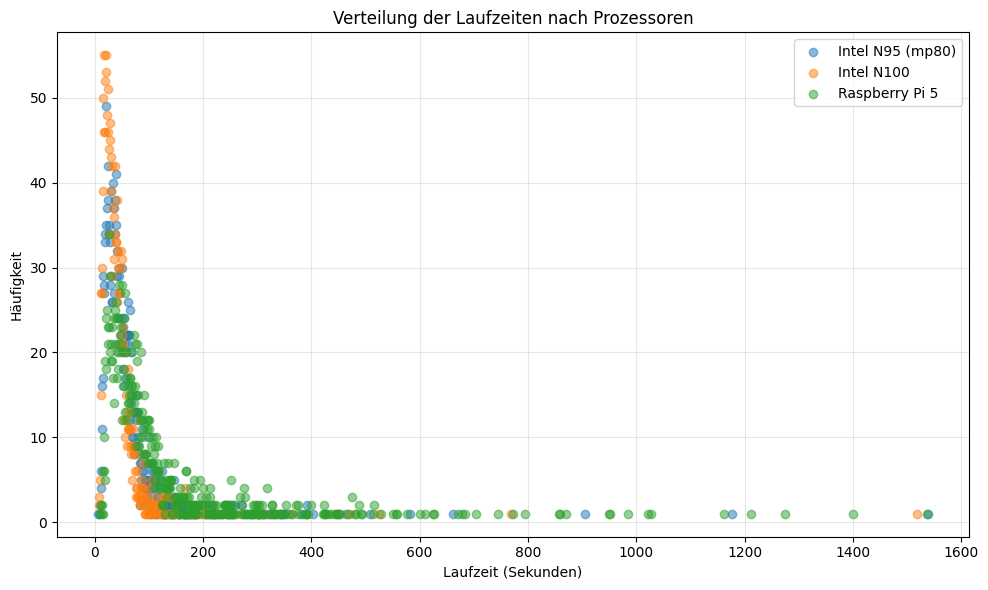

In [5]:
plt.ion()
plt.figure(figsize=(10, 6))

counts_dict = {}
for name, df in data.items():
    
    runtimes_rounded = df["runtime_s"] #.round(1)
    counts = runtimes_rounded.value_counts().sort_index()
    counts_dict[name]=counts
    counts = counts[(counts.index >= 0) & (counts.index <= 2000)]
    counts=counts[(counts.values>=0 )& (counts.values<=250)]
    plt.scatter(counts.index,counts.values , label=name,alpha=0.5)
    #plt.plot(counts.index, counts.values, label=name)
    
plt.xlabel("Laufzeit (Sekunden)")
plt.ylabel("Häufigkeit")
plt.title("Verteilung der Laufzeiten nach Prozessoren")
#plt.xlim(-10, 600)
#plt.ylim(-10, 80)
plt.legend()
plt.legend()
plt.tight_layout()
plt.savefig("runtime_distribution111.png") 
plt.grid(True, alpha=0.3)
plt.show()

counts_df=pd.DataFrame(counts_dict); counts_df = counts_df.fillna(0) # Laufzeiten und deren Haufigken in einem DataFrame gespeichert.
#print(counts_df)

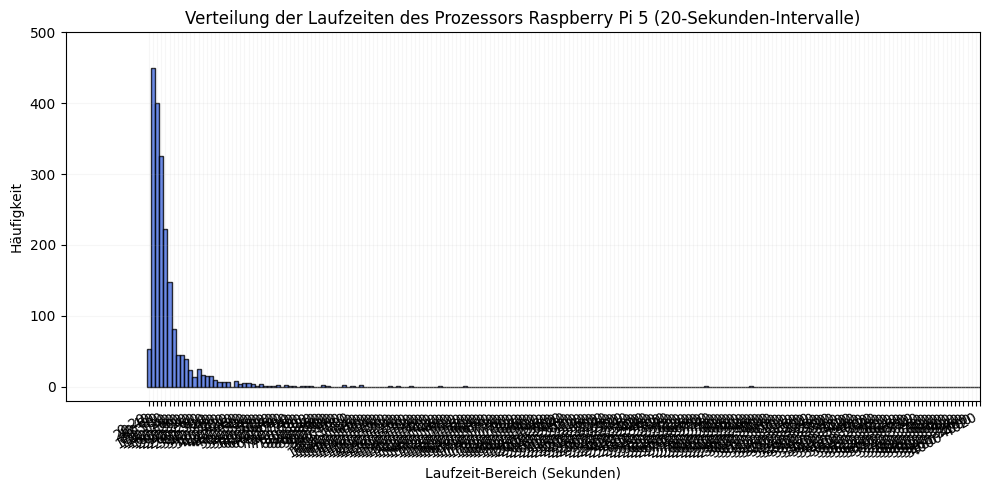

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df_Pi5 = data["Raspberry Pi 5"]
runtimes = df_Pi5["runtime_s"]

# 20-Sekunden-Intervalle
bins = np.arange(0, runtimes.max() + 20, 20)

# In Intervalle einteilen
categories = pd.cut(runtimes, bins=bins, right=True)

# Häufigkeit zählen
counts = categories.value_counts().sort_index()

# Labels schöner machen ([a, b])
labels = [f"{int(c.left)}-{int(c.right)}" for c in counts.index]

plt.figure(figsize=(10,5))
plt.bar(labels, counts.values, color="royalblue", edgecolor="black", width=1.0, alpha=0.8)

plt.xlabel("Laufzeit-Bereich (Sekunden)")
plt.ylabel("Häufigkeit")
plt.title("Verteilung der Laufzeiten des Prozessors Raspberry Pi 5 (20-Sekunden-Intervalle)")
plt.xticks(rotation=30, ha="right")

# Fokus auf Hauptbereich
plt.ylim(-20, 500)
plt.xlim(-20, 200)  # Zoom auf 0–200 Sekunden
plt.grid(True, alpha=0.1)
plt.tight_layout()
plt.show()


In [7]:
import json
import tarfile
from pathlib import Path

def load_dimensions(archive_path):
    """
    Lit toutes les instances JSON d'une archive .tar.gz
    et retourne une liste des dimensions trouvées.
    """
    dimensions = []

    with tarfile.open(archive_path, "r:gz") as tar:
        members = []
        for m in tar.getmembers():
            name = Path(m.name).stem
            parts = name.split('_')
            last = parts[-1]
            # On ne garde que les fichiers se terminant par un nombre (ex: _0.json)
            if last.isdigit():
                members.append(m)

        # Trier les fichiers dans l'ordre numérique (_0, _1, ..., _1999)
        members = sorted(members, key=lambda x: int(x.name.split('_')[-1].split('.')[0]))

        # Extraire la dimension de chaque fichier JSON
        for member in members:
            f = tar.extractfile(member)
            if f:
                js = json.load(f)
                if "dimension" in js:
                    dimensions.append(js["dimension"])

    # print(f"{len(dimensions)} dimensions lues depuis {archive_path}")
    return dimensions


In [8]:
import pandas as pd

def combine_dimensions_runtimes(dimensions, runtimes, n,label=None): 
    # Créer un DataFrame
    df = pd.DataFrame({
        'dimension': dimensions[:n],
        'runtime': runtimes[:n],
        'dataset': label
    })

    # print(f"✅ DataFrame créé avec {len(df)} lignes pour {label}")
    return df


In [9]:
# Methode zum Einlesen der Dimensionen aus JSON-Dateien in einem Ordner

def read_dimensions(folder: str, n=2000):
    dims = []
    stem = os.path.basename(folder)
    stems_to_try = [stem, stem + ".1"] if not stem.endswith(".1") else [stem, stem[:-2]]

    for i in range(n):
        candidates = []
        for s in stems_to_try:
            candidates.append(os.path.join(folder, f"{s}_{i}.json"))
            candidates.append(os.path.join(folder, f"{s}_{i}_sol.json"))
        path = next((p for p in candidates if os.path.exists(p)), None)
        if path is None:
            dims.append(None)
            continue
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)
        dims.append(data.get("dimension"))
    return dims


In [10]:
# Laden der Dimensionen aus den angegebenen Archiven
dims_300_700 = load_dimensions(r"C:\GitProjekts\PDA\b300_700.1.tar.gz")

dims_700_1000 = load_dimensions(r"C:\GitProjekts\PDA\b700_1000.1.tar.gz")

In [11]:
# Laden der Laufzeiten aus den angegebenen Dateien

runs_300_700 = read_and_compute_runtime(r"C:\GitProjekts\PDA\b300_700.1\runtimes.mp80")
runs_700_1000 =read_and_compute_runtime(r"C:\GitProjekts\PDA\b700_1000.1\runtimes.mp80")
#print(runs_300_700["runtime_s"])

# Laufzeiten und Dimensionen kombinieren
df_300_700 = combine_dimensions_runtimes(dims_300_700, runs_300_700["runtime_s"],len(runs_300_700), "b300_700.1")
df_700_1000 = combine_dimensions_runtimes(dims_700_1000, runs_700_1000["runtime_s"],len(runs_700_1000), "b700_1000.1")

# Daten zusammenführen
df_all = pd.concat([df_300_700, df_700_1000], ignore_index=True)

print(df_all)

      dimension  runtime      dataset
0           521     54.0   b300_700.1
1           339     16.0   b300_700.1
2           667    924.0   b300_700.1
3           554     53.0   b300_700.1
4           380     19.0   b300_700.1
...         ...      ...          ...
3995        761    286.0  b700_1000.1
3996        751    387.0  b700_1000.1
3997        708    303.0  b700_1000.1
3998        745    101.0  b700_1000.1
3999        704    331.0  b700_1000.1

[4000 rows x 3 columns]


In [12]:
extreme_row = df_all.loc[df_all["runtime"].idxmax()]
ext_x = extreme_row["dimension"]
ext_y = extreme_row["runtime"]

df_inst = df_all[(df_all["dataset"] == "b700_1000.1") &
                 (df_all["dimension"] == 838)]

print(df_inst)


      dimension  runtime      dataset
2031        838    141.0  b700_1000.1
2637        838    293.0  b700_1000.1
2673        838    534.0  b700_1000.1
2685        838    243.0  b700_1000.1
2849        838    133.0  b700_1000.1
3118        838     78.0  b700_1000.1
3252        838    161.0  b700_1000.1
3415        838     87.0  b700_1000.1
3522        838  31546.0  b700_1000.1


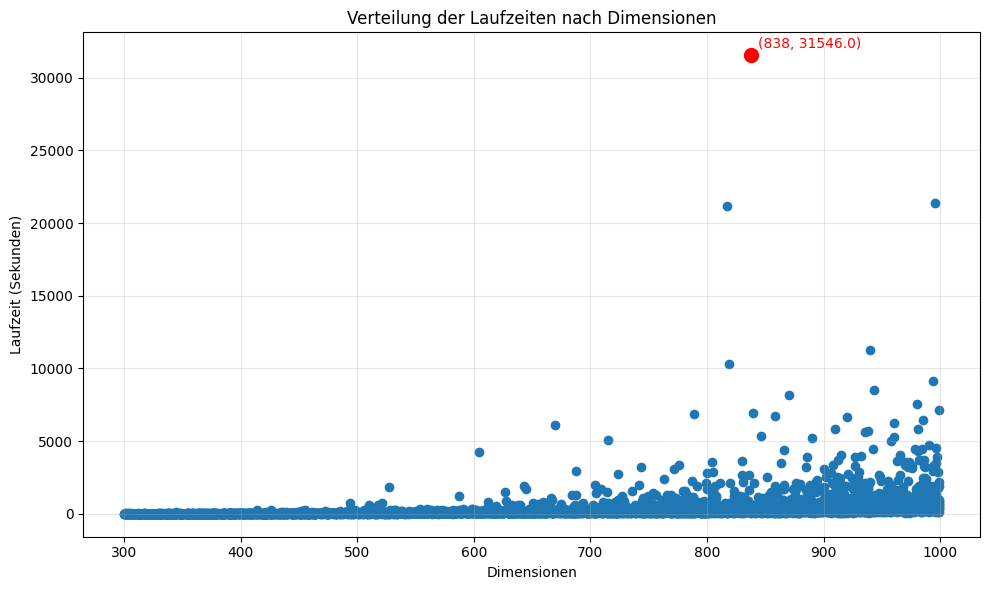

In [14]:
# Visualisierung der Verteilung der Laufzeiten nach Dimensionen

plt.ion()
plt.figure(figsize=(10, 6))
plt.scatter(df_all["dimension"],df_all["runtime"])
plt.scatter(ext_x, ext_y, s=100, color="red", label="Maximum Runtime")
plt.annotate(
    f"({ext_x}, {ext_y})",
    (ext_x, ext_y),
    textcoords="offset points",
    xytext=(5, 5),
    ha='left',
    color="red"
)
plt.xlabel("Dimensionen")
plt.ylabel("Laufzeit (Sekunden)")
plt.title("Verteilung der Laufzeiten nach Dimensionen")
#plt.xlim(-10, 600)
#plt.ylim(-10, 80)
plt.tight_layout()
plt.savefig("runtime_distribution111.png") 
plt.grid(True, alpha=0.3)
plt.show()

In [208]:
# Extremwerte finden und anzeigen   
extreme_row = df_all.loc[df_all["runtime"].idxmax()]
ext_x = extreme_row["dimension"]
ext_y = extreme_row["runtime"]

df_inst = df_all[(df_all["dataset"] == "b700_1000.1") &
                 (df_all["dimension"] == 838)]
print(df_inst)

      dimension  runtime      dataset dim_group  median_dimm
2673        838    534.0  b700_1000.1   820-839        830.0
3522        838  31546.0  b700_1000.1   820-839        830.0
2849        838    133.0  b700_1000.1   820-839        830.0
2031        838    141.0  b700_1000.1   820-839        830.0
3118        838     78.0  b700_1000.1   820-839        830.0
2685        838    243.0  b700_1000.1   820-839        830.0
3252        838    161.0  b700_1000.1   820-839        830.0
2637        838    293.0  b700_1000.1   820-839        830.0
3415        838     87.0  b700_1000.1   820-839        830.0


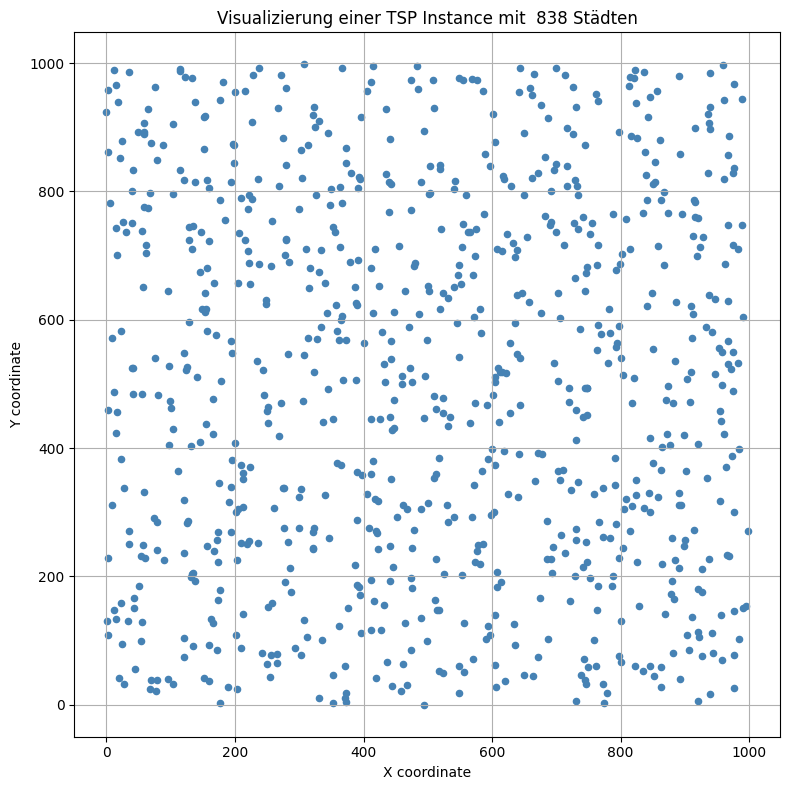

In [ ]:
#Visualisierung des Extremwert

# Datei laden
with open(r"C:\GitProjekts\PDA\b700_1000.1\b700_1000.1_1522_sol.json", "r") as f:
    data = json.load(f)

# Koordinaten extrahieren
coords = data["node_coordinates"]

# In zwei Listen aufteilen
x = [c[0] for c in coords]
y = [c[1] for c in coords]

# Plot
plt.figure(figsize=(8, 8))
plt.scatter(x, y, c='steelblue', s=20)
plt.title(f"Visualizierung einer TSP Instance mit  {len(coords)} Städten")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.grid(True)
plt.tight_layout()
plt.savefig("Instanceplot.png")
plt.show()

In [219]:

# 95%-Quantil der Laufzeiten je Dimension berechnen
bins= np.arange(300, 1000, 20)
labels = [f"{b}-{b+19}" for b in bins]

df_all["dim_group"] = pd.cut( df_all["dimension"],bins=np.append(bins, 1000),labels=labels,include_lowest=True)

quantiles = df_all.groupby("dim_group", observed=True)["runtime"].quantile(0.95).dropna()
 

In [220]:
# Median der Laufzeiten je Dimension berechnen und zum DataFrame hinzufügen
df_all=df_all.sort_values(by="dimension", ascending=True)

df_all["median_dimm"] = (
  df_all.groupby("dim_group", observed=True)["dimension"]
          .transform("median")
)

print( df_all)

      dimension  runtime      dataset dim_group  median_dimm
1624        300     10.0   b300_700.1   300-319        312.0
29          300      7.0   b300_700.1   300-319        312.0
749         301      9.0   b300_700.1   300-319        312.0
603         301     17.0   b300_700.1   300-319        312.0
376         301      8.0   b300_700.1   300-319        312.0
...         ...      ...          ...       ...          ...
3926        999    140.0  b700_1000.1   980-999        992.0
3528        999    913.0  b700_1000.1   980-999        992.0
3062        999    403.0  b700_1000.1   980-999        992.0
2344        999    702.0  b700_1000.1   980-999        992.0
3183        999    464.0  b700_1000.1   980-999        992.0

[4000 rows x 5 columns]


In [221]:
# Repräsentative Dimensionen pro Gruppe finden

df_representatives = df_all["median_dimm"].unique()
print(df_representatives)


[312.  332.  350.  370.5 391.  411.  429.  452.  472.  492.  511.  530.
 551.  572.  589.  610.  632.  651.  669.5 692.  711.  729.  751.  769.
 790.  809.  830.  851.  871.  891.  911.  930.  952.5 971.  992. ]


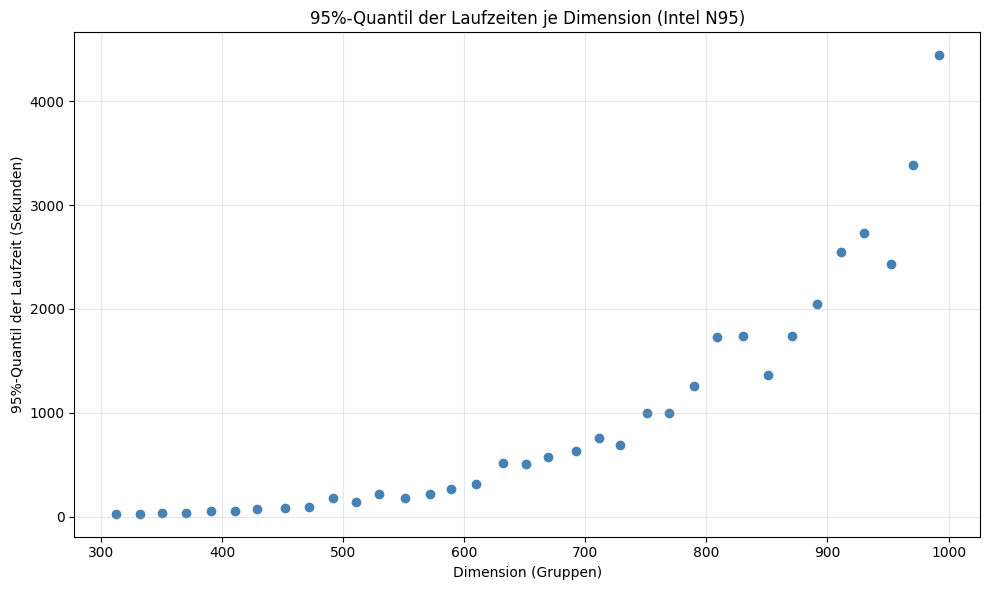

In [222]:
#Repräsentative Dimensionen pro einmal lesen
X2=[x for x in df_representatives]
# Plot 95% quantile vs dimension
plt.figure(figsize=(10, 6))
plt.scatter(X2, quantiles.values, marker="o", linestyle="-", color="steelblue")

plt.xlabel("Dimension (Gruppen)")
plt.ylabel("95%-Quantil der Laufzeit (Sekunden)")
plt.title("95%-Quantil der Laufzeiten je Dimension (Intel N95)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("quantile_95_plot.2.png")
plt.show()

In [223]:
# Lineare Regression auf den 95%-Quantilen durchführen Zweite Ansatz (hier wird die Dimension, deren Laufzeit gleich  oder am näherste der Median 
# der Entsprechende Bereich liegt,  als Repräsentant der Bereich verwendet)
anzahl_Bereiche=len(quantiles.index)
A=[X2,[1 for _ in range(anzahl_Bereiche)]]
y=np.array([a for a in np.log(quantiles.values)])
A=np.array(A).T
# print(A)
# print(A.shape)
A_T=A.T 
Anew=A_T@A
ynew=A_T@y
print(Anew)
print(ynew)

[[1.62499898e+07 2.27775000e+04]
 [2.27775000e+04 3.50000000e+01]]
[146680.94516501    209.07035047]


In [224]:
result=solve_linear_equation_system(Anew,ynew)
new_lambda1= np.exp(1.128781)
#print(lamda1) x[0] = 0,007444
# x[1] = 1,128781
new_lambda2=0.007444
f_x_2=[new_lambda1*np.exp(new_lambda2*x) for x in X2]
print(result)

[0.007444320974409964, 1.1287808422845023]


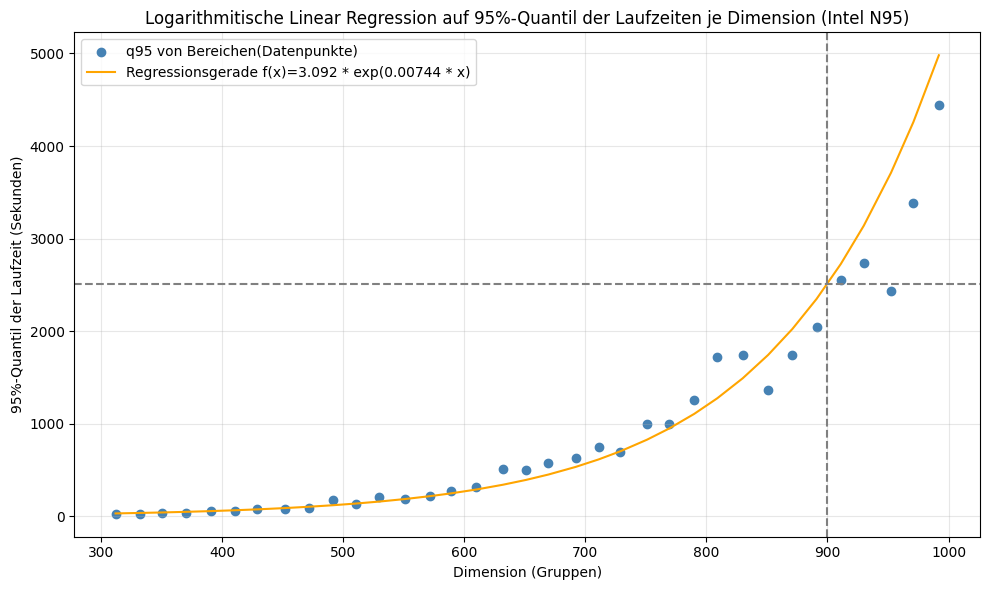

In [26]:
# Plot 95% quantile vs dimension mit Regressionsgerade
plt.figure(figsize=(10, 6))
plt.scatter(X2, quantiles.values, color="steelblue", label="q95 von Bereichen(Datenpunkte)")
plt.plot(X2,f_x_2,linestyle="-", color="orange", label=f"Regressionsgerade f(x)={new_lambda1:.3f} * exp({new_lambda2:.5f} * x)")
plt.axvline(900,linestyle="--", color="gray")
plt.axhline((new_lambda1*np.exp(new_lambda2*900)),linestyle="--", color="gray")
plt.xlabel("Dimension (Gruppen)")
plt.ylabel("95%-Quantil der Laufzeit (Sekunden)")

plt.title("Logarithmitische Linear Regression auf 95%-Quantil der Laufzeiten je Dimension (Intel N95)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("LogLinearRegress2.png")
plt.show()

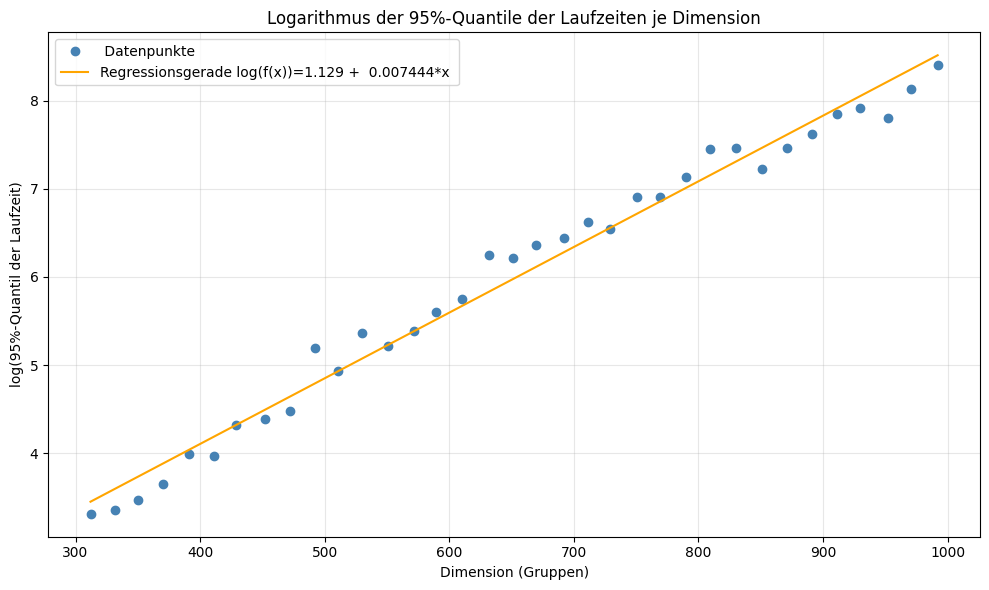

In [27]:
# Plot log(95% quantile) vs dimension mit Regressionsgerade

log_f_x_2=np.log(f_x_2)
plt.figure(figsize=(10, 6))

plt.plot(X2, np.log(quantiles.values),"o", color="steelblue", label=" Datenpunkte")
plt.plot(X2, log_f_x_2,color="Orange", label= f"Regressionsgerade log(f(x))={np.log(new_lambda1):.3f} + {new_lambda2: 5f}*x ")
plt.xlabel("Dimension (Gruppen)")
plt.ylabel("log(95%-Quantil der Laufzeit)")
plt.title("Logarithmus der 95%-Quantile der Laufzeiten je Dimension")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("Regress_quantile_log_plot_median.png")


plt.show()

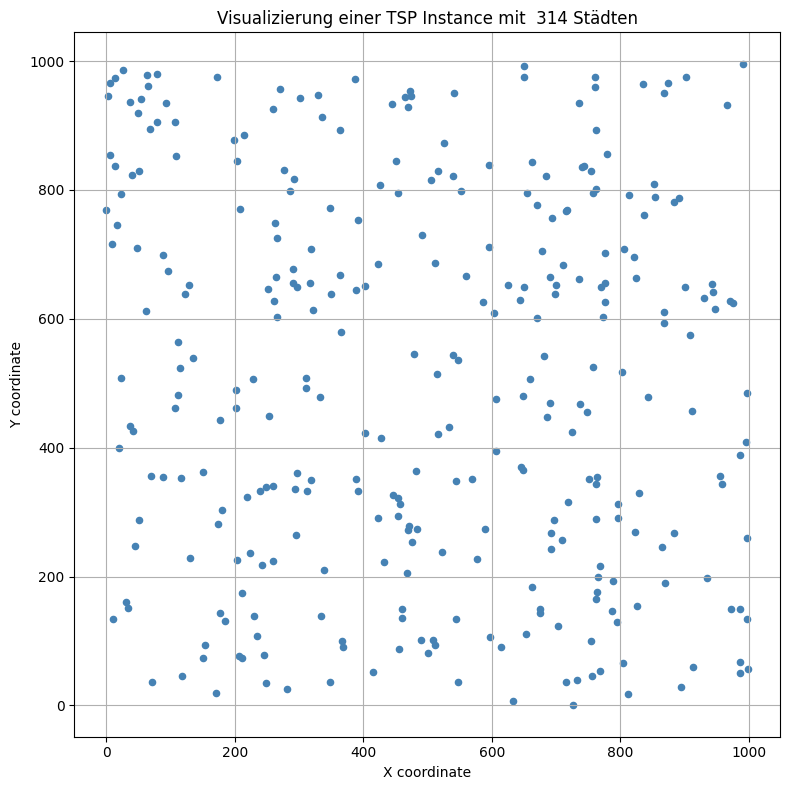

In [71]:
import json
import matplotlib.pyplot as plt

# Datei laden
with open(r"C:\GitProjekts\PDA\b300_700.1\b300_700.1_30_sol.json", "r") as f:
    data = json.load(f)

# Koordinaten extrahieren
coords = data["node_coordinates"]

# In zwei Listen aufteilen
x = [c[0] for c in coords]
y = [c[1] for c in coords]

# Plot
plt.figure(figsize=(8, 8))
plt.scatter(x, y, c='steelblue', s=20)
plt.title(f"Visualizierung einer TSP Instance mit  {len(coords)} Städten")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.grid(True)
plt.tight_layout()
plt.savefig("Instanceplot.png")
plt.show()


In [206]:
# ---------------- Modelbewertung ------------------
# Laden der Dimensionen aus den angegebenen Archiven
dims2_300_700 = load_dimensions(r"C:\GitProjekts\PDA\b300_700.2.tar.gz")

dims2_700_1000 = load_dimensions(r"C:\GitProjekts\PDA\b700_1000.2 (1).tar.gz")

In [207]:
# Laden der Laufzeiten aus den angegebenen Dateien

runs_300_700_2 = read_and_compute_runtime(r"C:\GitProjekts\PDA\b300_700.2\runtimes.mp80")
runs_700_1000_2 =read_and_compute_runtime(r"C:\GitProjekts\PDA\b700_1000.2(1)\runtimes.mp80")
#print(len(runs_700_1000_2))

# Laufzeiten und Dimensionen kombinieren
df_300_700_2 = combine_dimensions_runtimes(dims2_300_700, runs_300_700_2["runtime_s"],len(runs_300_700_2), "b300_700.2")
df_700_1000_2 = combine_dimensions_runtimes(dims2_700_1000, runs_700_1000_2["runtime_s"],len(runs_700_1000_2), "b700_1000.2")

# Daten zusammenführen
df_all_2 = pd.concat([df_300_700, df_700_1000], ignore_index=True)
print(df_all_2)

      dimension  runtime      dataset
0           521     54.0   b300_700.1
1           339     16.0   b300_700.1
2           667    924.0   b300_700.1
3           554     53.0   b300_700.1
4           380     19.0   b300_700.1
...         ...      ...          ...
3995        761    286.0  b700_1000.1
3996        751    387.0  b700_1000.1
3997        708    303.0  b700_1000.1
3998        745    101.0  b700_1000.1
3999        704    331.0  b700_1000.1

[4000 rows x 3 columns]


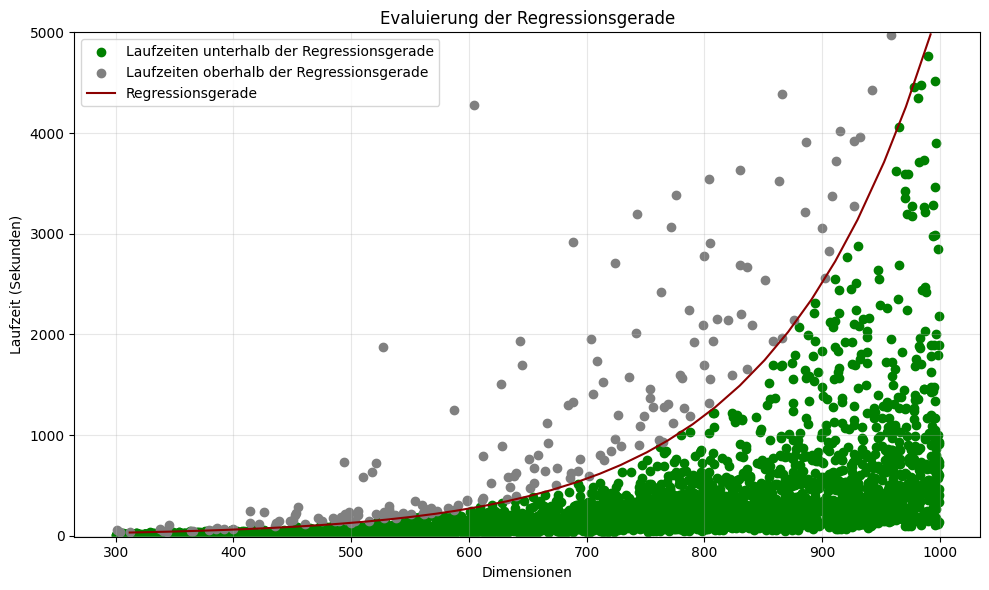

In [61]:

plt.ion()
plt.figure(figsize=(10, 6))
dimensions_x=df_all_2["dimension"].values
laufzeit_y=df_all_2["runtime"].values
Ypred=[new_lambda1*np.exp(new_lambda2*x) for x in dimensions_x]
f_x_=np.array(f_x_)
unter=laufzeit_y<Ypred 
over= laufzeit_y>=Ypred
plt.scatter(dimensions_x[unter],laufzeit_y[unter], color="green", label="Laufzeiten unterhalb der Regressionsgerade")
plt.scatter(dimensions_x[over],laufzeit_y[over], color="gray", label="Laufzeiten oberhalb der Regressionsgerade")
plt.plot(X2,f_x_2,linestyle="-", color="darkred", label="Regressionsgerade")
plt.xlabel("Dimensionen")
plt.ylabel("Laufzeit (Sekunden)")
plt.title("Evaluierung der Regressionsgerade")
#plt.xlim(-10, 600)
plt.ylim(-10, 5000)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("testLogLinearRegress.png") 
plt.show()

5.050000000000001
94.95


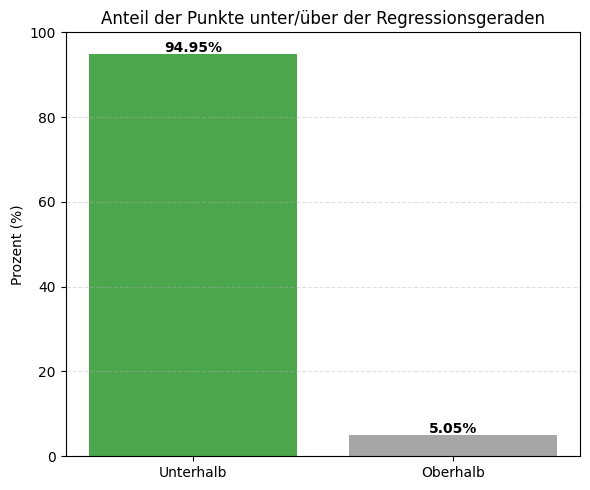

In [62]:
total = len(laufzeit_y)
p_unter = (np.sum(unter) / total) * 100
p_over = (np.sum(over) / total )*100
print(p_over )
print(p_unter)

labelshist = ["Unterhalb", "Oberhalb"]
percentages = [p_unter, p_over]
colors = ["green", "gray"]

plt.figure(figsize=(6, 5))
plt.bar(labelshist, percentages, color=colors, alpha=0.7)
plt.ylabel("Prozent (%)")
plt.title("Anteil der Punkte unter/über der Regressionsgeraden")

# Prozentwerte direkt auf die Balken schreiben
for i, v in enumerate(percentages):
    plt.text(i, v + 0.5, f"{v:.2f}%", ha="center", fontweight="bold")

plt.ylim(0, 100)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig("testHist.png")
plt.show()


In [ ]:
# Erste Schritt zur Bestimmung der Abhängigkeit der Laufzeit von dem Approximationsfaktor

import os
import json
import pandas as pd
import re

def summarize_tsp_folder(folder_path):
    """
    Liest alle _imp und _sol JSON-Dateien im Ordner und erstellt einen DataFrame mit:
    - Instanzname
    - Anzahl der Städte
    - Tourlänge _imp
    - Tourlänge _sol
    - GAP
    Sortiert nach Instanznummer aufsteigend, falls möglich.
    """
    # Zwischenspeicher
    instances = {}

    for filename in os.listdir(folder_path):
        if filename.endswith("_imp.json") or filename.endswith("_sol.json"):
            filepath = os.path.join(folder_path, filename)
            with open(filepath, 'r') as f:
                data = json.load(f)

            instance_name = filename.replace("b700_1000.2_", "").replace("_imp.json", "").replace("_sol.json", "")
            dimension = data.get("dimension", None)
            tour_length_value = data.get("tourlength", None)

            if instance_name not in instances:
                instances[instance_name] = {"dimension": dimension, "L_imp": None, "L_sol": None}

            if filename.endswith("_imp.json"):
                instances[instance_name]["L_imp"] = tour_length_value
            else:
                instances[instance_name]["L_sol"] = tour_length_value

    # DataFrame erstellen
    rows = []
    for inst, vals in instances.items():
        L_imp = vals["L_imp"]
        L_sol = vals["L_sol"]
        gap = (L_imp - L_sol) / L_sol if L_imp is not None and L_sol is not None and L_sol != 0 else None
        rows.append({
            "instance": inst,
            "dimension": vals["dimension"],
            "L_imp": L_imp,
            "L_sol": L_sol,
            "GAP": gap
        })

    df = pd.DataFrame(rows)

    # Versuch, Instanznummern numerisch zu sortieren
    def extract_number(name):
        match = re.search(r'\d+', name)
        return int(match.group()) if match else float('inf')  # Nicht numerische Namen ans Ende

    df = df.sort_values(by="instance", key=lambda x: x.map(extract_number)).reset_index(drop=True)

    return df

df_summary2 = summarize_tsp_folder(r"C:\GitProjekts\PDA\b700_1000.2(1)")

In [175]:
def read_and_compute_runtime_Prepro(filename):
    df = pd.read_csv(filename, sep=r"\s+", header=None,
                     names=["id", "start", "pre_end", "solver_end"])

    time_format = "%d.%m.%Y-%H:%M:%S"
    df["start"] = pd.to_datetime(df["start"], format=time_format)
    df["solver_end"] = pd.to_datetime(df["solver_end"], format=time_format)
    df["pre-end"] = pd.to_datetime(df["pre_end"], format=time_format)
    df["preprocessing_time"]=(df["pre-end"] - df["start"]).dt.total_seconds()
    df["runtime_s"] = (df["solver_end"] - df["start"]).dt.total_seconds()
    
    return df

In [176]:

runs_700_1000_2 =read_and_compute_runtime_Prepro(r"C:\GitProjekts\PDA\b700_1000.2(1)\runtimes.mp80")
#print(runs_700_1000_2 )
runs_700_1000_2.loc[runs_700_1000_2["id"] == 260, "runtime_s"] += 3600
#print(runs_700_1000_2.loc[runs_700_1000_2["id"] == 260]) 

df_summary2["Preprocessing"]=runs_700_1000_2["preprocessing_time"]
df_summary2["Total_runtime"]=runs_700_1000_2["runtime_s"]
print(df_summary2)

     instance  dimension  L_imp  L_sol       GAP  Preprocessing  Total_runtime
0           0        900  22008  21899  0.004977           11.0          663.0
1           1        923  22453  22309  0.006455           19.0          273.0
2           2        842  21220  21122  0.004640           12.0           81.0
3           3        848  21462  21349  0.005293           13.0           74.0
4           4        928  22409  22073  0.015222            8.0           96.0
...       ...        ...    ...    ...       ...            ...            ...
1995     1995        724  19652  19483  0.008674           10.0          411.0
1996     1996        722  19687  19471  0.011093            7.0          312.0
1997     1997        990  23219  22885  0.014595           19.0         1166.0
1998     1998        858  21610  21463  0.006849            9.0          639.0
1999     1999        737  20438  20299  0.006848           10.0          315.0

[2000 rows x 7 columns]


In [ ]:
bins= np.arange(700, 1000, 10)

labels = [f"{b}-{b+9}" for b in bins]

df_summary2["median_dimm"] = (
  df_summary2.groupby("dimension", observed=True)["dimension"]
          .transform("median")
)   
df_summary2["dim_group"] = pd.cut( df_summary2["dimension"],bins=np.append(bins, 1000),labels=labels,include_lowest=True)

print(df_summary2 )

     instance  dimension  L_imp  L_sol       GAP  Preprocessing  \
0           0        900  22008  21899  0.004977           11.0   
1           1        923  22453  22309  0.006455           19.0   
2           2        842  21220  21122  0.004640           12.0   
3           3        848  21462  21349  0.005293           13.0   
4           4        928  22409  22073  0.015222            8.0   
...       ...        ...    ...    ...       ...            ...   
1995     1995        724  19652  19483  0.008674           10.0   
1996     1996        722  19687  19471  0.011093            7.0   
1997     1997        990  23219  22885  0.014595           19.0   
1998     1998        858  21610  21463  0.006849            9.0   
1999     1999        737  20438  20299  0.006848           10.0   

      Total_runtime  median_dimm dim_group  
0             663.0        900.0   890-899  
1             273.0        923.0   920-929  
2              81.0        842.0   840-849  
3              

C:\Users\fonte\AppData\Local\Temp\ipykernel_30900\275616579.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g =df_summary2.groupby('dim_group')
C:\Users\fonte\AppData\Local\Temp\ipykernel_30900\275616579.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_summary2.groupby('dim_group')['GAP']


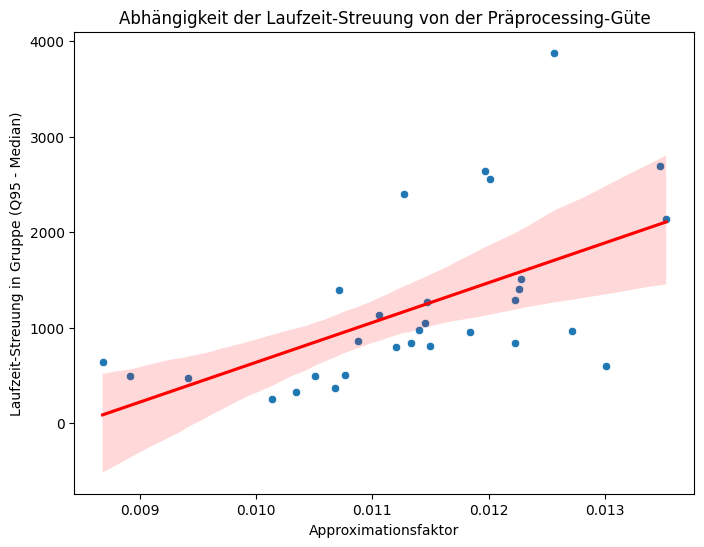

In [204]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Gruppen bilden und leere Gruppen entfernen
g =df_summary2.groupby('dim_group')
g = {k: v for k, v in g if len(v) > 0}   # nur nicht-leere Gruppen behalten

# 2. Streuung (Q95 - Median) pro Gruppe berechnen
spread = {
    k: np.percentile(v['Total_runtime'], 95) - np.median(v['Total_runtime'])
    for k, v in g.items()
}

# Dictionary -> DataFrame umwandeln
spread = (
    pd.DataFrame.from_dict(spread, orient='index', columns=['runtime_spread'])
    .reset_index()
    .rename(columns={'index': 'dim_group'})
)

# 3. Approximationsfaktor pro Gruppe berechnen
approx = (
    df_summary2.groupby('dim_group')['GAP']
    .mean()
    .reset_index()
)

# 4. Zusammenführen
merged = spread.merge(approx, on='dim_group', how='inner')


# 5. Plotten
plt.figure(figsize=(8,6))
sns.scatterplot(data=merged, x='GAP', y='runtime_spread')
sns.regplot(data=merged, x='GAP', y='runtime_spread', scatter=False, color='red')

plt.xlabel("Approximationsfaktor")
plt.ylabel("Laufzeit-Streuung in Gruppe (Q95 - Median)")
plt.title("Abhängigkeit der Laufzeit-Streuung von der Präprocessing-Güte")
plt.show()


In [205]:
print("Spread groups:", spread['dim_group'].unique())
print("Num spread groups:", len(spread))

print("Approx groups:", approx['dim_group'].unique())
print("Num approx groups:", len(approx))

print("Merged dataframe:")
print(merged)


Spread groups: ['700-709' '710-719' '720-729' '730-739' '740-749' '750-759' '760-769'
 '770-779' '780-789' '790-799' '800-809' '810-819' '820-829' '830-839'
 '840-849' '850-859' '860-869' '870-879' '880-889' '890-899' '900-909'
 '910-919' '920-929' '930-939' '940-949' '950-959' '960-969' '970-979'
 '980-989' '990-999']
Num spread groups: 30
Approx groups: ['700-709', '710-719', '720-729', '730-739', '740-749', ..., '950-959', '960-969', '970-979', '980-989', '990-999']
Length: 30
Categories (30, object): ['700-709' < '710-719' < '720-729' < '730-739' ... '960-969' < '970-979' < '980-989' < '990-999']
Num approx groups: 30
Merged dataframe:
   dim_group  runtime_spread       GAP
0    700-709          325.80  0.010347
1    710-719          368.00  0.010676
2    720-729          497.40  0.008914
3    730-739          641.50  0.008681
4    740-749          249.60  0.010139
5    750-759          474.00  0.009415
6    760-769          496.00  0.010504
7    770-779          500.00  0.010765
8

In [199]:
# indexes zu bestimmen wie geklustert ein Datensatzt ist. ==>  HOPKINS STATISTIC   wert 0.5 
# HOPKINS STATISTIC (index) 0 < H < 0.5  Datensatzt ist eher gleichmäßig verteilt
# HOPKINS STATISTIC (index) 0.5 < H < 1  Datensatzt ist eher geklustert   wie wird es tatsätlich berechnet?

#Gap--------------- Aproximationsfaktor/ Gütefaktor der Präprocessing-----------------


# Wie hängt die Güte der Präprocessing von Laufzeiten ab? Laufzetrang in Gruppen ( Gruppen von ungefähre gleiche Dimensionen) bilden

# tsp -i b500.1_1.json heuristic greedy  nicht optimal lösen ( gibt outpout aus)  ( Greedy ist ist name des Heuristik Algorithmus)  (kleine o nutzen !!)
# tsp -i b500.1_1.json heuristic greedy | tsp -c -O solve bac  (| ergebniss als imput für nächste Befehl) 
# tsp -i b500.1_1.json heuristic greedy | tsp improve 2opt | tsp -c -O solve bac 
## tsp -i b500.1_1.json heuristic greedy | tsp improve 2opt | tsp improve locenum -w 200 -s 100
# tsp -i b500.1_1.json heuristic greedy | tsp improve 2opt | tsp improve locenum -w 200 -s 100 | filer | tsp -c -O solve bac
# tsp -i b500.1_1.json heuristic greedy | tsp improve 2opt | tsp improve locenum -w 200 -s 100 | filer | tsp -c -O xxx.json solve bac (xxx.json ist die datei wo die lösung gespeichert wird)
# tsp -c -o  xxx.json solve bac  (starte direkt mit optimale Lösung)

# ssh [name]@ip-adresse  (um sich mit einem remote rechner zu verbinden) (name ist hier unsere benutzername auf dem remote rechner) 
# scp local-file [name]@ip-adresse:remote-file  (um dateien auf remote rechner zu kopieren)


# SSH Alternativee für Windows



#-------------------- Aufgaben für nächste Schritte ----------------------------
# geklusterte Instanzen  300-700  mit einem Gitter größe von 1000*1000 generieren
# Weiterhin Aproximationsfaktor  und Hopkins Index für die Instanzen berechnen


# etwa mit w spielen 







df_summary2["median_dimm"] = (
  df_summary2.groupby("dimension", observed=True)["dimension"]
          .transform("median")
)


In [133]:

df_representatives_com = df_summary2["median_dimm"].unique()